In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils import shuffle
import time
from itertools import chain, combinations, permutations
from IPython.display import Image, display
import urllib.request

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam
from sklearn.pipeline import Pipeline

# Challenge: Neural network regressor to predict photometric redshifts
In observational astronomy, measuring the redshift of a galaxy tells us how far away it is, and thus provides crucial information about the structure and evolution of the universe.

Traditionally, redshifts are measured using spectroscopy, which provides highly accurate values but is expensive and time-consuming — suitable only for a limited number of objects.

To overcome this, astronomers often use photometric redshifts (photo-z): estimates of a galaxy’s redshift derived from its brightness (magnitude) in a few broad photometric bands (e.g., ugriz, JHK). These estimates are much faster to obtain, but less precise.

Goal: Build a regression model that predicts the redshift of galaxies from their photometric features using a neural network.

In [6]:
url = 'https://www.researchgate.net/profile/Yuming-Fu/publication/344192975/figure/fig1/AS:993821525565440@1613956924645/Photometric-redshift-obtained-with-XGBoost-regression-model-against-spectral-redshift-of.png'

In [7]:
display(Image(url=url))
## Example figure!!! from Yuming Fu et al 2021 ApJS 254 6 (this is not what you will reproduce, but quite similar)

# A) The data

The data is based on the Sloan Digital Sky Survey (SDSS) DR16. Each row is a galaxy, and it contains 66 features + the spectroscopic redshift which is our label (supervised learning)
The features include:

- u,g,r,i,z: magnitudes of the objects in the SDSS. These represent the fluxes of light measured in logarithmic units, through various bands from the ultraviolet to the infrared
- 'ra' (right ascension) and 'dec' (declination): position of the object in the sky
- expRad: radius of the object
- expRadErr: error in the radius estimate
- 'z': spectroscopic redshift (or true redshift)




#### Answer the following questions:
- The data is already splitted into training, test and validation. What percentage of the total corresponds to training, validation and test?
- Make a histogram of the total spectroscopic redshift 'z', and individual histograms of 'z' for training, validation and test (use logscale in the y axis). Are these distributions similar? Do you think the training/testing/validation was done correctly?
- Apply a StandardScaler preprocessing

In [8]:
training = pd.read_csv('DR16_trainingset.csv')
validation = pd.read_csv('DR16_validationset.csv')
testing = pd.read_csv('DR16_testingset.csv')

In [9]:
training.keys()

Index(['dec', 'decErr', 'dered_g', 'dered_i', 'dered_r', 'dered_u', 'dered_z',
       'deVRad_g', 'deVRad_i', 'deVRad_r', 'deVRad_z', 'deVRadErr_g',
       'deVRadErr_i', 'deVRadErr_r', 'deVRadErr_z', 'expPhi_g', 'expPhi_i',
       'expPhi_r', 'expPhi_u', 'expPhi_z', 'expRad_g', 'expRad_i', 'expRad_r',
       'expRad_z', 'expRadErr_g', 'expRadErr_i', 'expRadErr_r', 'expRadErr_z',
       'extinction_g', 'extinction_i', 'extinction_r', 'extinction_u',
       'extinction_z', 'fiberMag_g', 'fiberMag_i', 'fiberMag_r', 'fiberMag_u',
       'fiberMag_z', 'fiberMagErr_g', 'fiberMagErr_i', 'fiberMagErr_r',
       'fiberMagErr_u', 'fiberMagErr_z', 'modelMag_g', 'modelMag_i',
       'modelMag_r', 'modelMag_u', 'modelMag_z', 'modelMagErr_g',
       'modelMagErr_i', 'modelMagErr_r', 'modelMagErr_u', 'modelMagErr_z',
       'petroRad_r', 'petroRadErr_r', 'psfMag_g', 'psfMag_i', 'psfMag_r',
       'psfMag_u', 'psfMag_z', 'psfMagErr_g', 'psfMagErr_i', 'psfMagErr_r',
       'psfMagErr_u', 'psfMagErr_z'

In [10]:
len(training)+len(validation)+len(testing)

119208

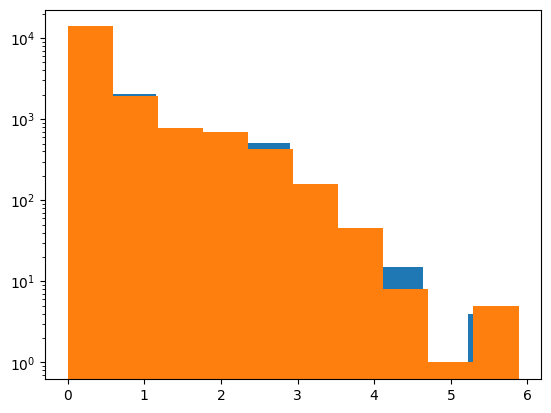

In [11]:
plt.hist(testing['z'])
plt.hist(validation['z'])
plt.yscale('log')

#### The distributions look similar for all sets of data, meaning they are all representative and not biased

In [12]:
y_train = training['z']
y_valid = validation['z']
y_test = testing['z']

X_train = training.drop(['z'],axis=1)
X_valid = validation.drop(['z'],axis=1)
X_test = testing.drop(['z'],axis=1)

In [13]:
scaler1 = StandardScaler().fit(X_train)
x_train = scaler1.transform(X_train)
x_test = scaler1.transform(X_test)
x_valid = scaler1.transform(X_valid)

## B) Let's train a neural network!
The following cell provides a baseline neural network architecture. Based on this, try the following modifications:

- Add more layers and/or increase the number of neurons.

- Include additional Dropout layers between Dense layers.

- Remove all Dropout layers.

- Change the learning rate to 0.1.

Observe the effect on the training and validation loss curves for each case.

Additionally, how does the model perform at high redshift values (z > 3)?


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 30)             │         2,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,331 (9.11 KB)

 Trainable params: 2,331 (9.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 2s 888us/step - loss: 0.3582 - mae: 0.3582 - val_loss: 0.2368 - val_mae: 0.2368
Epoch 2/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - loss: 0.2384 - mae: 0.2384 - val_loss: 0.1992 - val_mae: 0.1992
Epoch 3/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - loss: 0.2085 - mae: 0.2085 - val_loss: 0.1812 - val_mae: 0.1812
Epoch 4/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step - loss: 0.1866 - mae: 0.1866 - val_loss: 0.1702 - val_mae: 0.1702
Epoch 5/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step - loss: 0.1780 - mae: 0.1780 - val_loss: 0.1619 - val_mae: 0.1619
Epoch 6/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - loss: 0.1670 - mae: 0.1670 - val_loss: 0.1556 - val_mae: 0.1556
Epoch 7/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 592us/step - loss: 0.1607 - mae: 0.1607 - val_loss: 0.1501 - val_mae: 0.1501
Epoch 8/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 592us/step - loss: 0.1579 - mae: 0.1579 - val_loss: 0.1463 - val_mae: 0.1463
Epoch 9/100
835/835 ━━━━━━━━━━━━

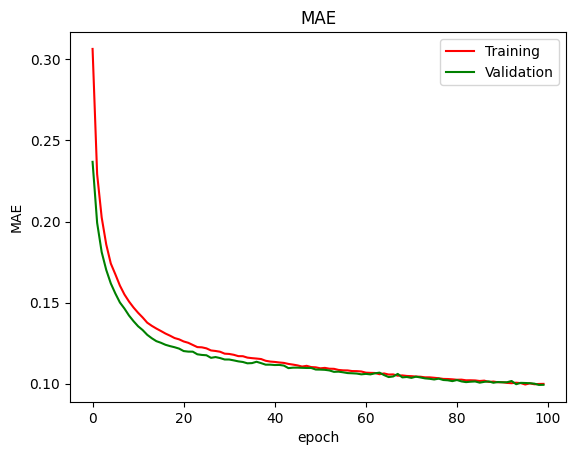

Testing 

559/559 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step


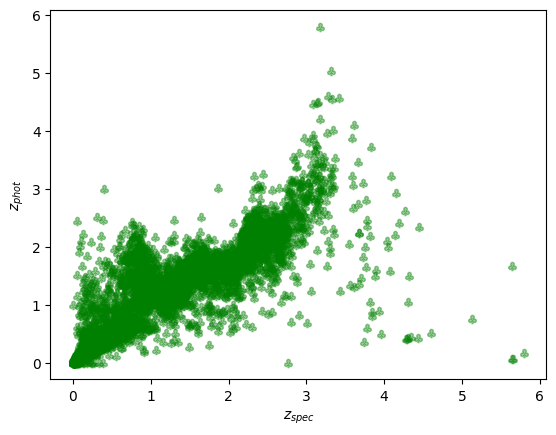

RMS Testing:  0.26595496254845885
MSE Testing:  0.07073204210415215
R2 Testing:  0.8289829583180464
Time:  53.83368229866028


In [14]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(66,)),
        keras.layers.Dense(30, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(1, activation='relu')
    ]
)
model.summary()
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['mae']
    )


start = time.time()

history = model.fit(x_train,y_train,validation_data=(x_valid, y_valid), batch_size=100, epochs=100, verbose = 1)
plt.plot(history.history['loss'],c='r',label='Training')
plt.plot(history.history['val_loss'],c='g',label='Validation')
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend()
plt.show()

print('Testing \n')

y_pred = model.predict(x_test)
plt.scatter(y_test,y_pred,alpha=0.4,marker=r'$\clubsuit$',c='g')
plt.xlabel('$z_{spec}$')
plt.ylabel('$z_{phot}$')
plt.show()

rms = np.sqrt(np.mean((np.array(pd.DataFrame(y_pred)[0]) - y_test)** 2))
print('RMS Testing: ', rms)
print('MSE Testing: ', mean_squared_error(y_pred, y_test))
print('R2 Testing: ', r2_score(y_test, y_pred))

print('Time: ', time.time()- start)


559/559 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


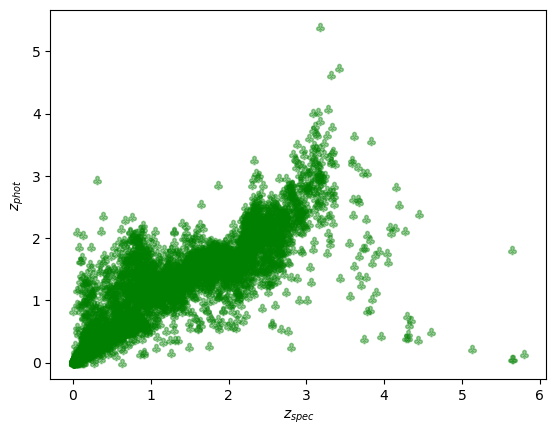

RMS Testing:  0.2665292140741696
MSE Testing:  0.07103782195499452
R2 Testing:  0.8282436389948462
Time:  95.32518005371094


In [25]:
y_pred = model.predict(x_test)
plt.scatter(y_test,y_pred,alpha=0.4,marker=r'$\clubsuit$',c='g')
plt.xlabel('$z_{spec}$')
plt.ylabel('$z_{phot}$')
plt.show()

rms = np.sqrt(np.mean((np.array(pd.DataFrame(y_pred)[0]) - y_test)** 2))
print('RMS Testing: ', rms)
print('MSE Testing: ', mean_squared_error(y_pred, y_test))
print('R2 Testing: ', r2_score(y_test, y_pred))

print('Time: ', time.time()- start)

### We observe that for z_spec > 3, the predictions are poor (they deviate from a linear relation). This can be due to the few number of examples

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 150)            │        10,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,851 (128.32 KB)

 Trainable params: 32,851 (128.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 837us/step - loss: 0.2490 - mae: 0.2490 - val_loss: 0.1687 - val_mae: 0.1687
Epoch 2/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - loss: 0.1606 - mae: 0.1606 - val_loss: 0.1541 - val_mae: 0.1541
Epoch 3/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 775us/step - loss: 0.1480 - mae: 0.1480 - val_loss: 0.1428 - val_mae: 0.1428
Epoch 4/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - loss: 0.1373 - mae: 0.1373 - val_loss: 0.1353 - val_mae: 0.1353
Epoch 5/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 755us/step - loss: 0.1265 - mae: 0.1265 - val_loss: 0.1292 - val_mae: 0.1292
Epoch 6/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - loss: 0.1231 - mae: 0.1231 - val_loss: 0.1264 - val_mae: 0.1264
Epoch 7/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - loss: 0.1190 - mae: 0.1190 - val_loss: 0.1237 - val_mae: 0.1237
Epoch 8/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - loss: 0.1187 - mae: 0.1187 - val_loss: 0.1205 - val_mae: 0.1205
Epoch 9/100
835/835 ━━━━━━━━━━━━

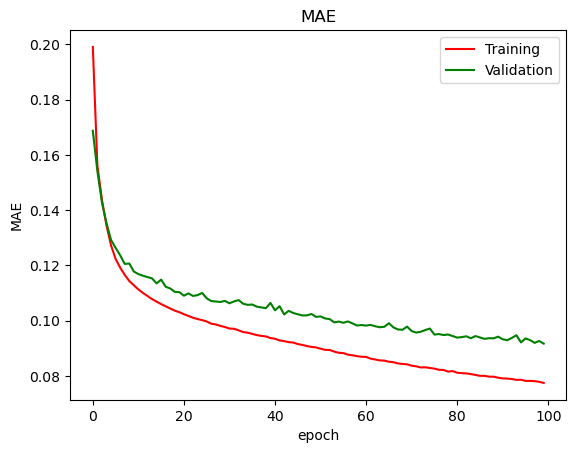

In [28]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(66,)),
        keras.layers.Dense(150, activation='relu'),
        #keras.layers.Dropout(0.1),
        keras.layers.Dense(150, activation='relu'),
        keras.layers.Dense(1, activation='relu')
    ]
)
model.summary()
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['mae']
    )


start = time.time()

history = model.fit(x_train,y_train,validation_data=(x_valid, y_valid), batch_size=100, epochs=100, verbose = 1)
plt.plot(history.history['loss'],c='r',label='Training')
plt.plot(history.history['val_loss'],c='g',label='Validation')
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend()
plt.show()



## Once we remove the Dropout layer, we observe overfitting (training curve in red performs better than validation/test)! Dropout is a good strategy to prevent it. Let's put it back and investigate the effect of the learning rate:

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 150)            │        10,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,851 (128.32 KB)

 Trainable params: 32,851 (128.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step - loss: 0.9931 - mae: 0.9931 - val_loss: 0.5491 - val_mae: 0.5491
Epoch 2/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 945us/step - loss: 0.5491 - mae: 0.5491 - val_loss: 0.5491 - val_mae: 0.5491
Epoch 3/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step - loss: 0.5459 - mae: 0.5459 - val_loss: 0.5491 - val_mae: 0.5491
Epoch 4/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - loss: 0.5435 - mae: 0.5435 - val_loss: 0.5491 - val_mae: 0.5491
Epoch 5/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - loss: 0.5441 - mae: 0.5441 - val_loss: 0.5491 - val_mae: 0.5491
Epoch 6/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - loss: 0.5469 - mae: 0.5469 - val_loss: 0.5491 - val_mae: 0.5491
Epoch 7/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - loss: 0.5446 - mae: 0.5446 - val_loss: 0.5491 - val_mae: 0.5491
Epoch 8/100
835/835 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step - loss: 0.5456 - mae: 0.5456 - val_loss: 0.5491 - val_mae: 0.5491
Epoch 9/100
835/835 ━━━━━━━━━━━━

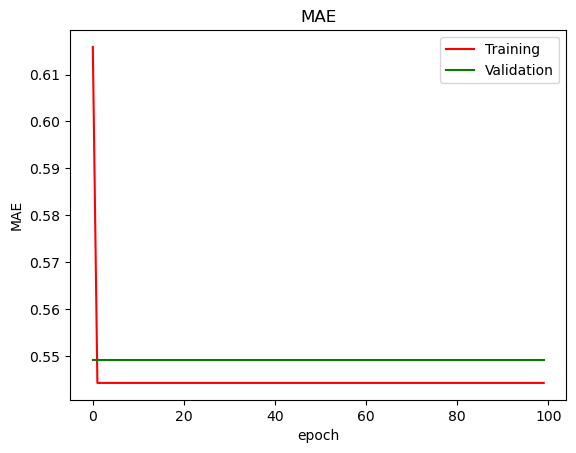

In [32]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(66,)),
        keras.layers.Dense(150, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(150, activation='relu'),
        keras.layers.Dense(1, activation='relu')
    ]
)
model.summary()
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              metrics=['mae']
    )


start = time.time()

history = model.fit(x_train,y_train,validation_data=(x_valid, y_valid), batch_size=100, epochs=100, verbose = 1)
plt.plot(history.history['loss'],c='r',label='Training')
plt.plot(history.history['val_loss'],c='g',label='Validation')
plt.title('MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend()
plt.show()



559/559 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


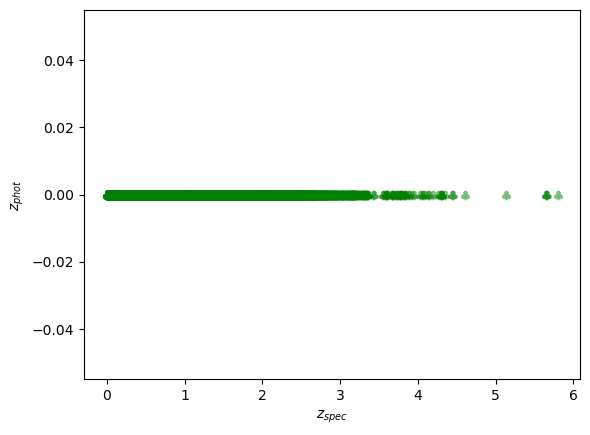

RMS Testing:  0.8424187918904295
MSE Testing:  0.7096694209301306
R2 Testing:  -0.7158498656225214
Time:  121.34511590003967


In [35]:
y_pred = model.predict(x_test)
plt.scatter(y_test,y_pred,alpha=0.4,marker=r'$\clubsuit$',c='g')
plt.xlabel('$z_{spec}$')
plt.ylabel('$z_{phot}$')
plt.show()

rms = np.sqrt(np.mean((np.array(pd.DataFrame(y_pred)[0]) - y_test)** 2))
print('RMS Testing: ', rms)
print('MSE Testing: ', mean_squared_error(y_pred, y_test))
print('R2 Testing: ', r2_score(y_test, y_pred))

print('Time: ', time.time()- start)

https://stackoverflow.com/questions/51181393/simple-linear-regression-using-keras

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

https://stackoverflow.com/questions/44132652/keras-how-to-perform-a-prediction-using-kerasregressor